TODO: 
- Use pyspark. Does it come with feature selection modules?
    The tree model implements feature importance.
    The logistic regression model can use L1 regularization.
    Doesn't do recursive elimination.
    Does chi-squared test.

- Metrics.
    + Use log-loss to evaluate.
    + precision, recall, F2
    + accuracy (ratio of correct)
- Models.
    Logistic regression, svm, decision tree, knn, naive bayes.
    All except logistic regression produces binary outputs.
- Target = 'click'. Not present in the test data set.

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [2]:
df = pd.read_csv('data/train_small.csv')
df.hour = pd.to_datetime(df.hour, format="%y%m%d%H")
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,11761126300016035614,0,2014-10-26 06:00:00,1002,0,6b175d24,a1b0ebd0,50e219e0,ecad2386,7801e8d9,...,0,0,15703,320,50,1722,0,35,-1,79
1,9454951464027616243,0,2014-10-26 06:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79
2,7597529435648422906,0,2014-10-24 07:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,...,1,2,21191,320,50,2424,1,161,100193,71
3,17674252474717503445,0,2014-10-26 16:00:00,1005,0,2b1ddb24,98acf46c,3e814130,ecad2386,7801e8d9,...,1,0,17239,320,50,1973,3,39,100148,23
4,14668325104229564251,0,2014-10-25 04:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,100083,79


In [126]:
sorted(df.hour.dt.day.unique())

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [5]:
# anonymized columns are already indexed.
anonymized = ['C1'] + ['C' + str(k) for k in range(14,22)]
df[anonymized].head()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,1002,15703,320,50,1722,0,35,-1,79
1,1005,15701,320,50,1722,0,35,-1,79
2,1005,21191,320,50,2424,1,161,100193,71
3,1005,17239,320,50,1973,3,39,100148,23
4,1005,15705,320,50,1722,0,35,100083,79


In [8]:
# these columns need indexing
str_cols = ['site_id','site_domain','site_category','app_id','app_domain','app_category','device_id','device_ip','device_model']
df[str_cols].head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model
0,6b175d24,a1b0ebd0,50e219e0,ecad2386,7801e8d9,07d7df22,54eeaef3,0d34e1f4,52c5cc40
1,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,fc61627b,711ee120
2,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,0f2161f8,a99f214a,68b6ba25,981edffc
3,2b1ddb24,98acf46c,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,75092a71,ecb851b2
4,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,5bb6c0b5,8a4875bd


In [9]:
# the rest
df.drop(anonymized, axis=1).drop(str_cols, axis=1).head()

,id,click,hour,banner_pos,device_type,device_conn_type
0,11761126300016035614,0,14102606,0,0,0
1,9454951464027616243,0,14102606,0,1,0
2,7597529435648422906,0,14102407,0,1,2
3,17674252474717503445,0,14102616,0,1,0
4,14668325104229564251,0,14102504,0,1,0


In [9]:
df.shape

(1000000, 24)

In [16]:
df.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,9.220259e+18,0.169773,1.410256e+07,1004.965138,0.287825,1.013995,0.331069,18838.292437,318.886996,59.991822,2112.033682,1.434757,227.270994,53287.068019,83.317616
std,5.324295e+18,0.375433,2.967422e+02,1.092803,0.504222,0.524993,0.854595,4967.153340,21.257371,46.927257,610.375812,1.326402,351.148578,49952.338638,70.310016
min,1.338641e+13,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,4.618979e+18,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,9.206212e+18,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100050.000000,61.000000
75%,1.383418e+19,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100094.000000,101.000000
max,1.844674e+19,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24044.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000


In [11]:
# 183MB?
df.memory_usage().sum()/(1024*1024)

183.1055450439453

In [6]:
df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [13]:
# slightly under 0.175, which is the mean in the full dataset
df.click.mean() 

0.169773

Compute the grouped mean for each variable

In [15]:
df.groupby('device_type')['click'].mean()

device_type
0    0.212078
1    0.168955
4    0.097977
5    0.097419
Name: click, dtype: float64

## Unique values
Some categorical features have high dimensions.

- Features that grow in number as the data size increases:
    + site_id
    + site_domain
    + app_id
    + app_domain
    + device_id
    + device_ip
    + device_model
    + C14
- medium growth:
    + site_category
    + app_categoy
    + C17
    + C20

In [34]:
def get_nuniques(df):
    unique_vals = dict()
    for c in df:
        unique_vals[c] = df[c].nunique()
    return unique_vals

def nuniques_to_df(unique_vals, name):
    return pd.DataFrame.from_dict(unique_vals, orient='index', columns=[name])

def sort_nuniques(unique_vals):
    return sorted(unique_vals.items(), key=lambda kv: kv[1])

In [37]:
# id shouldn't be included in the features
# Half of the rows have a unique device ip.
unique_vals_small = get_nuniques(df)
sort_nuniques(unique_vals)

[('click', 2),
 ('device_type', 4),
 ('device_conn_type', 4),
 ('C18', 4),
 ('C1', 7),
 ('banner_pos', 7),
 ('C15', 8),
 ('C16', 9),
 ('site_category', 22),
 ('app_category', 27),
 ('C21', 60),
 ('C19', 66),
 ('C20', 164),
 ('app_domain', 206),
 ('hour', 240),
 ('C17', 421),
 ('C14', 2254),
 ('site_id', 2667),
 ('site_domain', 2875),
 ('app_id', 3147),
 ('device_model', 5212),
 ('device_id', 150398),
 ('device_ip', 554960),
 ('id', 1000000)]

In [39]:
df_smaller = pd.read_csv('data/train_smaller.csv')
unique_vals_smaller = get_nuniques(df_smaller)
df_smallest = pd.read_csv('data/train_smallest.csv')
unique_vals_smallest = get_nuniques(df_smallest)
df_tiny = pd.read_csv('data/train_tiny.csv')
unique_vals_tiny = get_nuniques(df_tiny)

In [40]:
pd.concat([nuniques_to_df(unique_vals_tiny, 'tiny'),
    nuniques_to_df(unique_vals_smallest, 'smallest'), 
nuniques_to_df(unique_vals_smaller, 'smaller'),
          nuniques_to_df(unique_vals_small, 'small')], axis=1)

,tiny,smallest,smaller,small
id,1000,10000,100000,1000000
click,2,2,2,2
hour,231,239,240,240
C1,5,6,7,7
banner_pos,2,5,7,7
site_id,163,592,1444,2667
site_domain,130,476,1300,2875
site_category,9,18,18,22
app_id,107,446,1338,3147
app_domain,24,42,90,206


## site and app --- (id, domain, category) tuples

In [115]:
# about twice the number of unique site_id.
df.groupby(['site_id', 'site_domain']).size().shape,\
df.groupby(['site_id', 'site_domain', 'site_category']).size().shape

((5697,), (5699,))

In [116]:
# the number of unique tuples is about the same as that of app_id.
df.groupby(['app_id', 'app_domain']).size().shape,\
df.groupby(['app_id', 'app_domain', 'app_category']).size().shape

((3147,), (3148,))

## site and app --- null values
The site_id column in the train set does not seem to have null values.

In [64]:
# It is not the case that site_id == null iff site_domain == null iff site_category == null.
for site_var in ['site_id', 'site_domain', 'site_category']:
    counts = df[site_var].value_counts()
    print(site_var, counts.idxmax(), counts.max())
for app_var in ['app_id', 'app_domain', 'app_category']:
    counts = df[app_var].value_counts()
    print(app_var, counts.idxmax(), counts.max())

site_id 1fbe01fe 159901
site_domain c4e18dd6 374088
site_category 50e219e0 409141
app_id ecad2386 639121
app_domain 7801e8d9 673893
app_category 07d7df22 647524


In [93]:
df.site_id.value_counts().head(5)

1fbe01fe    159901
e151e245     65067
d9750ee7     24070
5b08c53b     22467
856e6d3f     19002
Name: site_id, dtype: int64

In [66]:
site_id_null = '1fbe01fe'
site_domain_null = 'c4e18dd6'
site_category_null = '50e219e0'
app_id_null = 'ecad2386'
app_domain_null = '7801e8d9'
app_category_null = '07d7df22'

In [76]:
# TODO: this seems wrong. site_id in the train set has no null value?
# if site_id == null, site_domain and site_category are not null
all(df[df.site_id == site_id_null].site_domain != site_domain_null),\
all(df[df.site_id == site_id_null].site_category != site_category_null)

(True, True)

In [77]:
# site_domain == null almost implies site_category == null
all(df[df.site_domain == site_domain_null].site_category == site_category_null),\
(df[df.site_domain == site_domain_null].site_category == site_category_null).mean()

(False, 0.9956961998246402)

In [78]:
# app_id == null implies app_domain == null and site_category == null
all(df[df.app_id == app_id_null].app_domain == app_domain_null),\
all(df[df.app_id == app_id_null].app_category == app_category_null)

(True, True)

In [79]:
# site_id and app_id are not mutually exclusive. 36% of the rows have both.
((df.site_id == site_id_null) ^ (df.app_id == app_id_null)).mean(),\
((df.site_id != site_id_null) & (df.app_id != app_id_null)).mean()

(0.47922, 0.360879)

In [80]:
# most of time either site_id or app_id exists.
((df.site_id != site_id_null) | (df.app_id != app_id_null)).mean()

0.840099

## device_id and ip

In [62]:
# device_ip doesn't have 
for device_var in ['device_id', 'device_ip']:
    counts = df[device_var].value_counts()
    print(counts.head(5))

a99f214a    824934
0f7c61dc       543
c357dbff       452
936e92fb       320
afeffc18       240
Name: device_id, dtype: int64
6b9769f2    5149
431b3174    3502
2f323f36    2214
930ec31d    2152
af62faf4    2149
Name: device_ip, dtype: int64


In [84]:
device_ip_null = 'a99f214a'

In [120]:
# The number of unique tuples is similar to that of device_ip.
df.groupby(['device_id', 'device_ip']).size().shape, df.device_id.nunique(), df.device_ip.nunique()

((608817,), 150398, 554960)

## Clicks by hour, weekday

In [9]:
# In the order of highest rate: Sat, Sun, Fri, Wed, Thur, Mon, Tue
# More ads on Mon-Wed, because the data is taken over 10 days.
df.groupby(df.hour.dt.weekday)['click'].agg(['mean', 'size', 'sum'])

,mean,size,sum
hour,,,
0,0.181572,79478,14431
1,0.162294,232787,37780
2,0.156913,226488,35539
3,0.175323,200550,35161
4,0.174470,83023,14485
5,0.180844,83044,15018
6,0.183441,94630,17359


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48e9ee5780>],
      dtype=object)

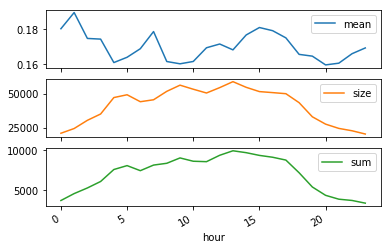

In [18]:
# Click rates have peaks: midnight, 7am, 3pm.
df.groupby(df.hour.dt.hour)['click'].agg(['mean', 'size', 'sum']).plot(subplots=True, layout=(3,1))

## Test dataset

In [86]:
df_test = pd.read_csv(gzip.open('data/test.gz'))

In [4]:
df_test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


In [3]:
df_test.shape

(4577464, 23)

In [13]:
# test dataset = 11th day. train = 1st-10th.
df.hour.min(), df.hour.max(), df_test.hour.min(), df_test.hour.max()

(14102100, 14103023, 14103100, 14103123)

In [89]:
# null values?
# It is not the case that site_id == null iff site_domain == null iff site_category == null.
for site_var in ['site_id', 'site_domain', 'site_category']:
    counts = df_test[site_var].value_counts()
    print(site_var, counts.idxmax(), counts.max())
for app_var in ['app_id', 'app_domain', 'app_category']:
    counts = df_test[app_var].value_counts()
    print(app_var, counts.idxmax(), counts.max())
for device_var in ['device_id', 'device_ip']:
    counts = df_test[device_var].value_counts()
    print(counts.head(2))

site_id 85f751fd 1719304
site_domain c4e18dd6 1759307
site_category 50e219e0 1866181
app_id ecad2386 2858160
app_domain 7801e8d9 2972631
app_category 07d7df22 2881854
a99f214a    3941701
afeffc18       2358
Name: device_id, dtype: int64
6b9769f2    19936
f1542531    12291
Name: device_ip, dtype: int64


In [94]:
df_test.site_id.value_counts().head(5)

85f751fd    1719304
17d1b03f     813053
1fbe01fe     429862
e151e245     268872
5b08c53b      95816
Name: site_id, dtype: int64

In [90]:
site_id_null = '85f751fd'
site_domain_null = 'c4e18dd6'
site_category_null = '50e219e0'
app_id_null = 'ecad2386'
app_domain_null = '7801e8d9'
app_category_null = '07d7df22'

In [92]:
# if site_id == null, site_domain and site_category are null
all(df_test[df_test.site_id == site_id_null].site_domain == site_domain_null),\
all(df_test[df_test.site_id == site_id_null].site_category == site_category_null)

(True, True)

In [95]:
# app_id == null implies app_domain == null and site_category == null
all(df_test[df_test.app_id == app_id_null].app_domain == app_domain_null),\
all(df_test[df_test.app_id == app_id_null].app_category == app_category_null)

(True, True)

In [102]:
# site_id and app_id are mutually exclusive.
all((df_test.site_id != site_id_null) ^ (df_test.app_id != app_id_null))

True

## Logistic regression

In [19]:
# consider:
# - class_weight='balanced'
# - solver='sag'
# - n_jobs=2
train_cols = df.columns.drop('click')
X = df[df.columns.drop(['id','click'])].values
y = df.click.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(1e5))
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=int(1e5))
clf = LogisticRegression(random_state=0,
                        solver='liblinear',
                        class_weight=None,
                        )

In [20]:
%%time
clf.fit(X_train, y_train)

ValueError: could not convert string to float: '1aa0e912'

In [ ]:
clf.score(X_train, y_train), clf.score(X_dev, y_dev)